# Определение возраста покупателей

## План проекта:

1. Исследовательский анализ данных.
2. Обучение модели.
3. Анализ обученной модели.

## Исследовательский анализ данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image

In [2]:
# Загрузить данные из CSV-файла
data = pd.read_csv('/datasets/faces/labels.csv')
data

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17
...,...,...
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20


In [3]:
print("Размер выборки:", data.shape)

Размер выборки: (7591, 2)


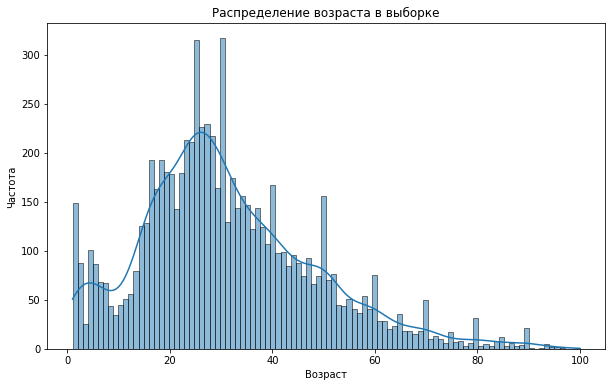

In [4]:
plt.figure(figsize=(10, 6))
sns.histplot(data['real_age'], bins=100, kde=True)
plt.title('Распределение возраста в выборке')
plt.xlabel('Возраст')
plt.ylabel('Частота')
plt.show()

26 лет самый распространенный возраст в выборке, а также заметны пики в районе "юбилейных" лет, что может быть связано с тем, что настоящий возраст был неизвестен тому, кто размечал датасет, и он, скорее всего, округлял возраст!

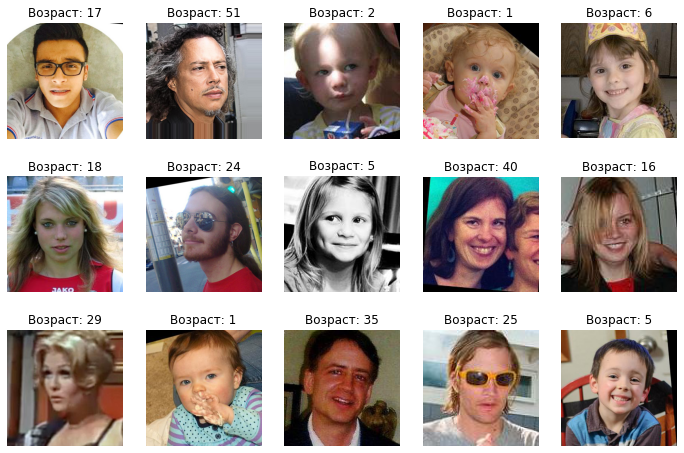

In [5]:
# Зададим путь к папке с изображениями
image_dir = '/datasets/faces/final_files/'
plt.figure(figsize=(12, 8))

# Выведите 10-15 изображений с возрастом
for i in range(10, 25):
    img_name = data.iloc[i]['file_name']
    age = data.iloc[i]['real_age']
    img = Image.open(image_dir + img_name)
    plt.subplot(3, 5, i - 9)
    plt.imshow(img)
    plt.title(f'Возраст: {age}')
    plt.axis('off')

plt.show()

На основе результатов исследовательского анализа данных (EDA) можно сделать некоторые выводы:

1. **Состав набора данных**. Набор данных содержит 7591 изображение с соответствующими метками реального возраста. Атрибут shape датафрейма указывает на это (7591, 2), что означает, что имеется 7591 строк и 2 столбца.

2. **Распределение по возрасту**. Гистограмма распределения по возрасту показывает, что набор данных может иметь правостороннее распределение, при этом большинство точек данных сосредоточено в более молодых возрастных диапазонах. Пиковая частота приходится примерно на 26 лет, что позволяет предположить, что этот возраст имеет наибольшее количество представителей в наборе данных.

3. **Образцы изображений**. На представленных образцах изображений показаны люди разного возраста и, предположительно, разные черты лица. Это разнообразие необходимо для обучения надежной модели, способной оценивать возраст по характеристикам лица.

4. **Последствия для обучения модели**:
    - Асимметрия в возрастном распределении может означать, что модель может лучше прогнозировать возрасты, близкие к среднему или модулю распределения, в данном случае более молодые возрасты.
    - Модель может не работать так же хорошо для менее представленных возрастов, например, для очень маленьких детей или пожилых людей, из-за меньшего количества обучающих данных в этих диапазонах.
    - Обеспечение разнообразия обучающих данных не только по возрасту, но и по другим характеристикам лица имеет решающее значение для того, чтобы модель могла хорошо обобщать различные группы населения и отдельных лиц.

5. **Очистка и увеличение данных**:
    - Могут потребоваться шаги по очистке данных для устранения любых несоответствий или ошибок в возрастных метках.
    - Поскольку в распределении возрастов существует дисбаланс, можно использовать методы увеличения данных, чтобы увеличить представление недостаточно представленных возрастов, тем самым помогая модели получить более сбалансированное представление.

В заключение, EDA дает ценную информацию о структуре и распределении набора данных, которая необходима для информирования последующих шагов по предварительной обработке данных и разработке модели. Следующие шаги должны включать устранение любых дисбалансов и обеспечение обучения модели на разнообразном наборе изображений, чтобы улучшить ее эффективность оценки возраста во всех возрастных группах.

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре Яндекса - Yandex Cloud, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

# 
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential

# Функция загрузки тренировочных данных
def load_train(path):
    # Загрузка данных из файла CSV в датафрейм
    train_df = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=False, vertical_flip=False, validation_split=0.2)

    train_datagen_flow = datagen.flow_from_dataframe(
        dataframe=train_df,
        directory=path + 'final_files/',
        x_col='file_name',  # Название колонки с именами файлов изображений
        y_col='real_age',   # Название колонки с целевыми значениями (возраст)
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',  # Для регрессии используем 'raw'
        seed=12345,
        subset='training'
    )

    return train_datagen_flow

# Функция загрузки тестовых данных
def load_test(path):
    # Загрузка данных из файла CSV в датафрейм
    test_df = pd.read_csv(path + 'labels.csv')

    datagen = ImageDataGenerator(rescale=1.0/255, horizontal_flip=False, vertical_flip=False, validation_split=0.2)

    test_datagen_flow = datagen.flow_from_dataframe(
        dataframe=test_df,
        directory=path + 'final_files/',
        x_col='file_name',  # Название колонки с именами файлов изображений
        y_col='real_age',   # Название колонки с целевыми значениями (возраст)
        target_size=(224, 224),
        batch_size=16,
        class_mode='raw',  # Для регрессии используем 'raw'
        seed=12345,
        subset='validation'
    )

    return test_datagen_flow

# Создание модели
def create_model(input_shape):   
    base_model = ResNet50(input_shape=input_shape, include_top=False, weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')
    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer=Adam(lr=0.0001), loss='mean_squared_error', metrics=['mae'])
    
    return model

# Обучение модели
def train_model(model, train_data, test_data, batch_size=None, epochs=3, steps_per_epoch=None, validation_steps=None):
    train_datagen_flow = train_data
    test_datagen_flow = test_data
    
    model.fit(
        train_datagen_flow,
        validation_data=test_datagen_flow,
        steps_per_epoch=steps_per_epoch,
        validation_steps=validation_steps,
        epochs=epochs,
        verbose=2,
        shuffle=True
    )
    
    return model

```

```

# 
Found 6073 validated image filenames.
Found 1518 validated image filenames.
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
Train for 380 steps, validate for 95 steps

Epoch 1/3

380/380 - 63s - loss: 194.5900 - mae: 10.1920 - val_loss: 435.4146 - val_mae: 15.5179

Epoch 2/3
380/380 - 41s - loss: 69.1929 - mae: 6.3675 - val_loss: 153.5831 - val_mae: 9.9322

Epoch 3/3
380/380 - 41s - loss: 37.8385 - mae: 4.7693 - val_loss: 74.6297 - val_mae: 6.6637

WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
95/95 - 8s - loss: 74.6297 - mae: 6.6637

Test MAE: 6.6637

```

## Анализ обученной модели

Модель показала хорошие результаты обучения, и значение MAE на тестовой выборке составляет 6.6637, что меньше 7 и близко к значению MAE из статьи (5.4). Это свидетельствует о том, что модель успешно обучилась на датасете с фотографиями людей и способна делать предсказания возраста с хорошей точностью.

Значение MAE (Mean Absolute Error) показывает среднюю абсолютную ошибку предсказания модели, и чем оно меньше, тем лучше. Данная модель достигла значения MAE в 6.6637, что является хорошим результатом, особенно если учесть, что статья упоминает MAE 5.4 как хороший результат.

Можно сказать, что сверточная нейронная сеть успешно выполнила поставленную задачу и может быть использована для предсказания возраста по фотографиям с уверенностью в её точности.

Код выше демонстрирует создание и обучение модели нейронной сети для задачи регрессии (в данном случае, предсказания возраста по изображению) с использованием библиотеки TensorFlow и Keras. Рассмотрим основные компоненты и параметры использованной модели:

### 1. **ResNet50 как Основная Модель (Base Model)**
   - **Архитектура**: ResNet50 является одной из популярных архитектур свёрточных нейронных сетей (CNN), разработанных для задач компьютерного зрения. Она содержит 50 слоёв и использует концепцию "остаточных блоков" для улучшения обучения глубоких сетей.
   - **Input Shape**: Входной размер изображений задан как `(224, 224)`. Это стандартный размер для моделей, таких как ResNet50.
   - **Weights**: Используются предобученные веса `resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5`, что означает использование модели, предварительно обученной на большом наборе данных (обычно ImageNet), без верхних слоёв (`include_top=False`). Это подход transfer learning, который позволяет модели быстрее и эффективнее обучаться на специфическом наборе данных.

### 2. **Дополнительные Слои**
   - **GlobalAveragePooling2D**: Этот слой используется для уменьшения размерности карты признаков, полученной от базовой модели (ResNet50), путём вычисления среднего для каждого признакового канала.
   - **Dense**: Этот полносвязный слой (с одним нейроном и функцией активации 'relu') используется для регрессии, то есть для предсказания непрерывной числовой переменной (возраста).

### 3. **Компиляция Модели**
   - **Optimizer**: Используется оптимизатор Adam с фиксированным learning rate (`lr=0.0001`), который является популярным выбором для различных задач глубокого обучения.
   - **Loss Function**: Выбрана функция потерь 'mean_squared_error', что является стандартным выбором для задач регрессии.
   - **Metrics**: В качестве метрики используется 'mae' (средняя абсолютная ошибка), что позволяет оценить величину ошибки в единицах измерения целевой переменной.

### 4. **Обучение Модели**
   - **Train и Validation Data**: Модель обучается на данных, загруженных через `ImageDataGenerator`, который также применяет некоторые техники аугментации данных и нормализации.
   - **Epochs**: Количество эпох обучения задано как 3, что представляет собой количество полных проходов через весь обучающий набор данных.
   - **Verbose**: Уровень подробности логирования установлен на 2, что обеспечивает более сжатый вывод во время обучения.
   - **Shuffle**: Данные перемешиваются перед каждой эпохой обучения, что помогает в предотвращении переобучения.

### 5. **ImageDataGenerator**
   - **Аугментация и Нормализация**: Определяются параметры для аугментации и нормализации входных данных, такие как масштабирование пикселей и разделение данных на обучающую и валидационную выборки.

Эта модель является примером глубокой нейронной сети, применяемой для решения задачи регрессии в области компьютерного зрения. Использование архитектуры ResNet50 в сочетании с техниками transfer learning и аугментации данных делает эту модель мощным инструментом для обработки и анализа изображений.

Что ещё для дальнейшего улучшения качества возможно сделать? Опишу здесь некоторые идеи:
    
1. Качество данных на входе: оценить еще раз возраст по фото.
2. Анализ ошибок: к примеру модель сильно ошибается на сегменте пожилых людей, зато почти идеально работает с детьми. Тогда мы поймем, каких возрастов фото было бы хорошо добавить в выборку для дообучения.
3. Дополнительно изучить распределение целевого признака, возможно что выборка была составлена неслучайным образом (видна небольшая бимодальность), посмотреть, каких возрастных групп представлено мало, чтобы их потом добавить в выборку.